In [1]:
%%capture
%%shell
git clone https://github.com/plarotta/vision-encoder.git
mv /content/vision-encoder/transfer_learner/ /content/
rm -rf /content/vision-encoder/
# wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1zxFDf6wqacM4EfMzLp2YD7kI9g-3KtJk' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1zxFDf6wqacM4EfMzLp2YD7kI9g-3KtJk" -O UR5_images_2.zip && rm -rf /tmp/cookies.txt
# wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1TAMiAfoJIyFmvGo5gLzxftRHprF60PzG' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1TAMiAfoJIyFmvGo5gLzxftRHprF60PzG" -O UR5_positions_2.csv && rm -rf /tmp/cookies.txt
wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1M16MVlj7pFdaw_JB0iwEe2xFlmeBhgkY' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1M16MVlj7pFdaw_JB0iwEe2xFlmeBhgkY" -O UR5_images_3.zip && rm -rf /tmp/cookies.txt
wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1CDgE1eaYw0R-PdWPWFRXKWpowmSN7pMh' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1CDgE1eaYw0R-PdWPWFRXKWpowmSN7pMh" -O UR5_positions_3.csv && rm -rf /tmp/cookies.txt
unzip UR5_images_3.zip
mv UR5_images_3/ images/
rm UR5_images_3.zip
pip install wandb -qq

In [1]:
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split
import torch
import os
from skimage import io
from torchvision.transforms import v2
from matplotlib import pyplot as plt
from torchvision.models.resnet import ResNet18_Weights
from torchvision.models import resnet18
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from transfer_learner.source.model import RobotNet
from transfer_learner.source.robot_dataset import RobotImageDataset
from transfer_learner.utils.trainers import train_one_epoch, validate_one_epoch
import wandb

/usr/local/lib/python3.10/dist-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

In [2]:
class RobotImageDataset(Dataset):
    #TODO: make multi_input = False functional. Right now it fails
    def __init__(self, csv_file: str, root_dir: str, multi_input = False):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
        """
        self.annotations = pd.read_csv(csv_file)
        self.annotations = self.annotations[['ImageID','Joint3','Joint4','Joint5', 'Joint6']]
        self.root_dir = root_dir
        self.multi_input = multi_input
        self.file_names = ["side_view_",
                           "front_view_",
                           "top_view_",
                           "corner1_view_",
                           "corner2_view_",
                           "side_depth_view_",
                           "front_depth_view_",
                           "top_depth_view_",
                           "corner1_depth_view_",
                           "corner2_depth_view_"]

        #TODO: improve transform so that the final image view is more zoomed in

        if self.multi_input:
            self.transform = v2.Compose(
                [
                    v2.ToDtype(torch.float32),
                    v2.ToTensor(),
                    v2.Resize(size=(224, 224), antialias=True),
                    v2.Normalize(mean=[0.485, 0.456, 0.406], #default resnet norm
                                std=[0.229, 0.224, 0.225]),
                    v2.ToTensor()
                ])
        else:
            self.transform = v2.Compose(
                [
                    v2.ToDtype(torch.float32),
                    v2.ToTensor(),
                    v2.Resize(size=(224, 224), antialias=True),
                    v2.Grayscale(),
                    v2.ToTensor()
                ])

    def process_images(self, images):
        for im_idx in range(len(images)):
            if len(images[im_idx].shape) > 2:
                images[im_idx] = images[im_idx][:,:,:3]
            images[im_idx] = self.transform(images[im_idx])
        out = [im for im in images] if self.multi_input else torch.cat([im for im in images],dim = 0)
        return(out)

    def __len__(self):
        return(len(self.annotations))

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        images = [io.imread(os.path.join(self.root_dir, f + str(idx) + '.png')) for f in self.file_names]
        im_data = self.process_images(images)
        joint_values = self.annotations.iloc[idx, 1:].to_numpy(dtype=float)
        sample = {'images': im_data, 'joint_values': joint_values}
        return sample

In [4]:
robotdata = RobotImageDataset('/content/UR5_positions_3.csv', '/content/images', multi_input=False)


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


torch.Size([10, 224, 224])


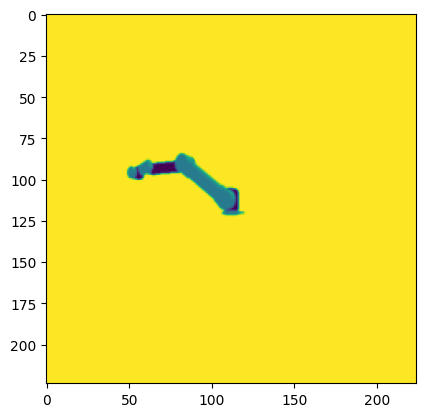

In [5]:
print(robotdata[0]['images'].shape)
plt.imshow(robotdata[0]['images'][0])

In [3]:
# RUN THIS MODEL!!!
class RobotNet(nn.Module):
    def __init__(self, n_hidden_units1, n_hidden_units2, n_inputs=1, freeze_resnet = False):
        super().__init__()
        self.num_inputs = n_inputs
        self.in_dim1 = n_hidden_units1
        self.in_dim2 = n_hidden_units2
        self.weights = ResNet18_Weights.DEFAULT

        self.base_model = resnet18(weights=self.weights)
        self.base_layers = list(self.base_model.children())
        self.flatten = nn.Flatten()

        # freeze resnet layers
        if freeze_resnet:
            for idx,child in enumerate(self.base_layers):
              for param in child.parameters():
                param.requires_grad = False


        self.resnet_layers = nn.Sequential(
            nn.Conv2d(10, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
            *self.base_layers[1:-1])

        self.linear_output = nn.Sequential(
            nn.Linear(in_features=512*self.num_inputs, out_features=self.in_dim1),
            nn.ReLU(),
            nn.Linear(in_features=self.in_dim1, out_features=self.in_dim2),
            nn.ReLU(),
            nn.Linear(in_features=self.in_dim2, out_features=4)
        )


    def forward(self, inputs):

        if self.num_inputs > 1:
            for idx in range(len(inputs)):
                inputs[idx] = self.resnet_layers(inputs[idx])
            out = self.linear_output(torch.cat(inputs,dim=1).view(-1,512*len(inputs)))
        else:
            out = self.resnet_layers(inputs)
            out = self.linear_output(self.flatten(out))

        return out

In [7]:
robotdata = RobotImageDataset('/content/UR5_positions_3.csv', '/content/images', multi_input=False)


def train_one_epoch(tr_loader, model, loss_func, optimizer, device,feedback=None):
    running_loss = 0.0
    fback = 0.0

    for i, data in enumerate(tr_loader):
        im1 = data['images']
        y = data['joint_values'].float()
        im1,y = im1.to(device), y.to(device)
        optimizer.zero_grad()
        # print('model in',im1.shape)
        preds = model(im1).float()
        preds_hat = torch.cat([torch.sin(preds),torch.cos(preds)],dim=1)
        y_hat = torch.cat([torch.sin(y),torch.cos(y)],dim=1)
        loss = loss_func(preds_hat, y_hat)

        running_loss +=loss.item()
        loss.backward()
        optimizer.step()
        if feedback:
            fback += feedback(preds,y).item()


    train_loss = running_loss/(i+1)
    if feedback:
        return(train_loss,fback/(i+1))
    else:
      return(train_loss)

def validate_one_epoch(val_loader, model, loss_func, optimizer, device,feedback=None):
    running_loss = 0.0
    fback = 0.0

    with torch.no_grad():
        for i, data in enumerate(val_loader):
            im1 = data['images']
            y = data['joint_values'].float()
            im1, y = im1.to(device), y.to(device)
            optimizer.zero_grad()
            preds = model(im1).float()
            preds_hat = torch.cat([torch.sin(preds),torch.cos(preds)],dim=1)
            y_hat = torch.cat([torch.sin(y),torch.cos(y)],dim=1)
            loss = loss_func(preds_hat, y_hat)
            running_loss +=loss.item()
            if feedback:
                fback += feedback(preds,y)
    val_loss = running_loss/(i+1)

    if feedback:
        return(val_loss,fback/(i+1))
    else:
      return(val_loss)

def main():
    run = wandb.init(project='vision-encoder')
    LEARNING_RATE = 2e-4
    BATCH_SIZE = 32
    EPOCH = 75
    IN_DIM1 = 128
    IN_DIM2 = 32


    # Check if GPU is available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    # Params
    traindata, validdata = random_split(robotdata, [0.8,0.2])
    trainloader = DataLoader(traindata, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
    validloader = DataLoader(validdata, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
    multi_model = RobotNet(IN_DIM1, IN_DIM2,n_inputs=1)


    # Initialize
    multi_model.to(device)
    criterion = nn.MSELoss()
    feedback = nn.MSELoss()
    optimizer = optim.AdamW(multi_model.parameters(), lr=LEARNING_RATE, weight_decay=0.0001)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max= 1000)

    for epoch in range(1,EPOCH):

        tr_loss,t_fback = train_one_epoch(trainloader, multi_model, criterion, optimizer, device, feedback)
        val_loss,v_fback = validate_one_epoch(validloader, multi_model, criterion, optimizer, device, feedback)
        wandb.log(
            {
                "epoch": epoch,
                "train_loss": tr_loss,
                "val_loss": val_loss,
                "train_feedback": t_fback,
                "val_feedback": v_fback
            }
        )
        print(f'epoch: {epoch} | train loss: {tr_loss} | val loss: {val_loss} | "train_feedback": {t_fback} | "val_feedback": {v_fback}')
        scheduler.step()
        # saving to the wandb dir ensures that the model files are accessible on the portal once the run finishes
        torch.save(multi_model.state_dict(),os.path.join(wandb.run.dir, f"model_state_dict_epoch{epoch}.pth"))
    run.finish()
    torch.save(multi_model.state_dict(), 'model_state.pth')

main()

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


cuda:0


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 65.4MB/s]


epoch: 1 | train loss: 0.080116210475564 | val loss: 0.03143449322808357 | "train_feedback": 0.17515040537714957 | "val_feedback": 0.06533923745155334
epoch: 2 | train loss: 0.02382286062464118 | val loss: 0.01975704330418791 | "train_feedback": 0.048949614115059374 | "val_feedback": 0.040636900812387466
epoch: 3 | train loss: 0.016372106993570924 | val loss: 0.014759953843340987 | "train_feedback": 0.03325502410903573 | "val_feedback": 0.03000614605844021
epoch: 4 | train loss: 0.012648445716127754 | val loss: 0.011595853064800538 | "train_feedback": 0.02557595120370388 | "val_feedback": 0.023546267300844193
epoch: 5 | train loss: 0.010196672932244837 | val loss: 0.010518932035045019 | "train_feedback": 0.02056405888311565 | "val_feedback": 0.021355168893933296
epoch: 6 | train loss: 0.009289134982973337 | val loss: 0.00938397589775305 | "train_feedback": 0.018723077110946177 | "val_feedback": 0.01902698166668415
epoch: 7 | train loss: 0.0076891130106523636 | val loss: 0.0082366383996

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_feedback,█▃▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▃▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_feedback,█▅▃▃▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▃▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,74
train_feedback,0.00172
train_loss,0.00086
val_feedback,0.00703
val_loss,0.00309


In [10]:
multi_model = RobotNet(128,32)
multi_model.load_state_dict(torch.load('/content/wandb/latest-run/files/model_state_dict_epoch70.pth'))

<All keys matched successfully>

In [29]:
robotdata = RobotImageDataset('/content/UR5_positions_3.csv', '/content/images', multi_input=False)
loader = DataLoader(robotdata, batch_size=10, shuffle=True)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


In [30]:
running_loss = 0.0
fback = 0.0
device = 'cpu'
loss_f = nn.MSELoss()
feed = nn.MSELoss()

with torch.no_grad():
    for i, data in enumerate(loader):
        im1 = data['images']
        y = data['joint_values'].float()
        preds = multi_model(im1).float()
        preds_hat = torch.cat([torch.sin(preds),torch.cos(preds)],dim=1)
        y_hat = torch.cat([torch.sin(y),torch.cos(y)],dim=1)
        loss = loss_f(preds_hat, y_hat)
        running_loss +=loss.item()
        feed_l = feed(preds,y)
        fback += feed_l.item()
        print(loss.item(),feed_l.item())
        print(f'gt: {y}, pred: {preds}')
        input()

val_loss = running_loss/(i+1)
feed_loss = fback/(i+1)

0.0014974653022363782 0.0029966768343001604
gt: tensor([[-0.9371, -1.5443,  0.1657,  0.1101],
        [-1.5646, -0.0287, -0.7468, -1.2957],
        [ 0.5278, -1.3250,  0.2066,  0.0881],
        [ 0.6543,  0.5727, -0.5525,  0.7712],
        [-0.1550,  0.0242,  1.2605,  0.0384],
        [-0.2924,  0.0795, -1.2657, -0.6176],
        [ 0.2246, -0.4158,  0.0580,  0.3474],
        [ 0.4635, -0.4300,  1.3248, -0.8876],
        [-0.2401, -1.1433,  0.6444,  1.0012],
        [ 0.4013, -1.4451, -0.2776,  1.5260]]), pred: tensor([[-0.9624, -1.4749,  0.1441,  0.1512],
        [-1.5664,  0.0124, -0.7704, -1.2280],
        [ 0.5720, -1.2998,  0.2296,  0.0403],
        [ 0.7130,  0.6698, -0.6481,  0.8246],
        [-0.2014,  0.0744,  1.2545,  0.1440],
        [-0.2896,  0.1460, -1.3044, -0.7105],
        [ 0.2597, -0.3658,  0.0375,  0.2624],
        [ 0.5394, -0.4446,  1.3474, -0.8950],
        [-0.2788, -1.0843,  0.6643,  0.9910],
        [ 0.4807, -1.3254, -0.2823,  1.4999]])


KeyboardInterrupt: ignored